### Clustering

In [1]:
import re
import random
import spacy
import numpy as np
import itertools
import collections
import functools
import operator
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from sklearn.metrics.pairwise import euclidean_distances

Load data

In [2]:
def load_data(path):
    func_names = []
    func_types = []
    func_comments = []
    with open(path, "r") as file:
        for name, types, comments in (x for x in map(lambda l: l.strip().split("|"), file.readlines()) if len(x) == 3):
            func_types.append(types.split(","))
            func_comments.append(comments.split(","))
            func_names.append(name)
    return func_names, func_types, func_comments

def printk(funcs, k=10, show_sort=True, nmap=None, rand=False):
    print(f"#funcs={len(funcs)}\nfuncs:")
    indices = random.choices(range(len(funcs)), k=k) if rand else range(k)
    print(*((funcs[i], nmap[funcs[i]]) if nmap else funcs[i] for i in indices), sep='\n')
    if show_sort:
        print("\nsorted:", *((f, nmap[f]) if nmap else f for f, _ in zip(sorted(funcs), range(k))), sep='\n')

func_names, func_types, func_comments = load_data("functions.txt")
printk(func_names)

#funcs=2808444
funcs:
arswitch_readphy_internal
rbs_spill_82
get_preset_color
hash_collide
__wt_esc_hex_to_raw
GD_SFLASH_GetNames
strreverse
do_pcmcia_entry
sym_remque_head
image_scale_confirm_large

sorted:
$$$$$$_PauseResumeOverheadOnce
$$$$$$_PauseResumeOverheadThrice
$$$$$$_PauseResumeOverheadTwice
$$RTX$$version
$$USBD$$version
$$divI
$$divI_10
$$divI_12
$$divI_14
$$divI_15


Drop wrong names

In [3]:
def drop_wrong_names(func_names, func_types, func_comments):
    re_ident = re.compile(rf"^[a-zA-Z_][a-zA-Z_0-9]*$", re.UNICODE)
    func_names, func_types, func_comments = map(
        list, zip(*(itertools.filterfalse(lambda x: not re_ident.fullmatch(x[0]),
                                          zip(func_names, func_types, func_comments)))))
    return func_names, func_types, func_comments

func_names, func_types, func_comments = drop_wrong_names(func_names, func_types, func_comments)
printk(func_names)

#funcs=2806093
funcs:
arswitch_readphy_internal
rbs_spill_82
get_preset_color
hash_collide
__wt_esc_hex_to_raw
GD_SFLASH_GetNames
strreverse
do_pcmcia_entry
sym_remque_head
image_scale_confirm_large

sorted:
A
A
A
A
A
A
A
A
A
A


Split names to tokens

In [4]:
def tokenize_funcs(funcs):
    oneword = re.compile(r"^[a-z][a-z0-9]+|[A-Z][A-Z0-9]$")
    difCase = re.compile(r".+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)")
    under_scores_split = re.compile(r"_")

    tokenized_funcs = []
    for f in funcs:
        if oneword.fullmatch(f):
            tokenized_funcs.append([f])
        elif "_" in f:
            tokenized_funcs.append([w for w in under_scores_split.split(f) if w])
        else:
            tokenized_funcs.append([w.group(0) for w in difCase.finditer(f) if w.group(0)])
    return tokenized_funcs

tokenized_func_names = tokenize_funcs(func_names)
tokenized_func_names = [tok_name + tok_comm for tok_name, tok_comm in zip(tokenized_func_names, func_comments)]
name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)
del name2tokens

#funcs=2806093
funcs:
('set_so_opentype', ['set', 'so', 'opentype', ''])
('qtnf_cmd_send_change_intf_type', ['qtnf', 'cmd', 'send', 'change', 'intf', 'type', ''])
('dissect_lpp_T_errorCause', ['dissect', 'lpp', 'T', 'errorCause', ''])
('ControlSetTime', ['Control', 'Set', 'Time', ''])
('settings_nvs_src', ['settings', 'nvs', 'src', ''])
('cdValidateTime', ['cd', 'Validate', 'Time', 'Validate', 'the', 'component', 'time', 'return', '0', 'if', 'valid', '1', 'if', 'not'])
('cadence_spi_write_speed', ['cadence', 'spi', 'write', 'speed', ''])
('iflib_calc_rx_mbuf_sz', ['iflib', 'calc', 'rx', 'mbuf', 'sz', ''])
('highHalf', ['high', 'Half', 'Returns', 'the', 'value', 'of', 'the', 'upper', 'half', 'of', 'PART'])
('rt_timer_check', ['rt', 'timer', 'check', ''])

sorted:
('A', ['A', ''])
('A', ['A', ''])
('A', ['A', ''])
('A', ['A', ''])
('A', ['A', ''])
('A', ['A', ''])
('A', ['A', ''])
('A', ['A', ''])
('A', ['A', ''])
('A', ['A', ''])


Drop digits from tokens, convert to low register

In [5]:
def drop_wrong_symbols(func_names, tokenized_func_names, func_types):
    # first approach to drop all digits, second only if > 50%
    wrong_char = re.compile(r"[\d]")
    tokenized_func_names_ = []
    func_types_ = []
    func_names_ = []
    for i, (name, tokenized_name, types) in enumerate(zip(func_names, tokenized_func_names, func_types)):
        processed_tokens = [wrong_char.sub("", token).lower() for token in tokenized_name if wrong_char.sub("", token)]
        if processed_tokens:
            tokenized_func_names_.append(processed_tokens)
            func_types_.append(types)
            func_names_.append(name)

    return func_names_, tokenized_func_names_, func_types_

func_names, tokenized_func_names, func_types = drop_wrong_symbols(func_names, tokenized_func_names, func_types)
name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)
del name2tokens

#funcs=2806086
funcs:
('ntpq_queryhost', ['ntpq', 'queryhost', 'ntpq', 'queryhost', 'sends', 'a', 'mode', 'query', 'packet', 'to', 'the', 'current', 'open', 'host', 'see', 'ntpq', 'openhost', 'and', 'stores', 'the', 'requested', 'variable', 'set', 'in', 'the', 'specified', 'character', 'buffer', 'it', 'returns', 'the', 'number', 'of', 'bytes', 'read', 'or', 'zero', 'for', 'an', 'empty', 'result', 'no', 'answer', 'or', 'empty', 'value', 'parameters', 'varset', 'u', 'short', 'which', 'variable', 'set', 'should', 'be', 'read', 'peervars', 'or', 'clockvars', 'association', 'int', 'the', 'association', 'id', 'that', 'should', 'be', 'read', 'represents', 'the', 'ntpd', 'instance', 'itself', 'resultbuf', 'char', 'the', 'resulting', 'string', 'without', 'quoted', 'characters', 'maxlen', 'int', 'max', 'number', 'of', 'bytes', 'for', 'varvalue', 'returns', 'int', 'number', 'of', 'bytes', 'that', 'have', 'been', 'copied', 'to', 'resultbuf', 'or', 'zero', 'if', 'no', 'reply', 'has', 'been', 'recei

Split concatenated words to separate tokens

In [6]:
def create_segment_func(tokenized_func_names, c=1, base=1/26, prior=1e-8):
    word2count = collections.Counter(itertools.chain(*tokenized_func_names))
    total_num_words = sum(word2count.values())
    corrected_total_num_words = (len(word2count) + 1) * c + total_num_words
    word2prob1 = {k: v / total_num_words for k, v in word2count.items()}
    word2prob2 = {k: (v + c) / corrected_total_num_words for k, v in word2count.items()}
    unseen_prob = c / corrected_total_num_words
    ones_length2count = collections.Counter(map(len, (word for word, count in word2count.items() if count == 1)))
    ones_longest = max(ones_length2count)
    ones_num_words = sum(ones_length2count.values())

    # naive probability v1
    def prob1(word):
        return word2prob1[word]

    # smoothed probability v1
    def prob2(word):
        return word2prob2[word] if word in word2prob2 else unseen_prob

    # smoothed probability v2
    def prob3(word):
        unseen_estimation = ones_length2count[len(word)] / ones_num_words if len(word) in ones_length2count \
            else ones_length2count[ones_longest] / ones_num_words * base ** (len(word) - ones_longest) \
            if len(word) > ones_longest else base ** len(word)
        return word2prob1[word] if word in word2prob1 else prior * unseen_estimation

    def split(word, start=1, end=20):
        return ((word[:i], word[i:]) for i in range(start, min(len(word) + 1, end)))

    @functools.lru_cache(maxsize=10000)
    def segment(word, maxlen=500):
        if not word:
            return []
        if len(word) > maxlen:
            return segment(word[:maxlen]) + segment(word[maxlen:]) 
        candidates = ([first] + segment(remaining) for first, remaining in split(word))
        return max(candidates, key=lambda x: functools.reduce(operator.__mul__, map(prob3, x), 1))
    return segment

def segmentize_corpus(tokenized_func_names, segmenter):
    tokenized_func_names = [list(itertools.chain(*(segmenter(token) for token in tokens)))
                            for tokens in tokenized_func_names]
    return tokenized_func_names

segmenter = create_segment_func(tokenized_func_names)
words = ["ccfileutils", "setendframeindex", "inneractionframe", "setsearchresolutionsorder",
         "dynamicmeminit", "wakeupiodisableglobal", "getinit", "getinitz"]
print(*((word, segmenter(word)) for word in words), "", sep='\n')
tokenized_func_names = segmentize_corpus(tokenized_func_names, segmenter)

name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)
del words, name2tokens

('ccfileutils', ['ccfileutils'])
('setendframeindex', ['setendframeindex'])
('inneractionframe', ['inneractionframe'])
('setsearchresolutionsorder', ['set', 'search', 'resolutions', 'order'])
('dynamicmeminit', ['dynamicmeminit'])
('wakeupiodisableglobal', ['wakeupiodisable', 'global'])
('getinit', ['get', 'init'])
('getinitz', ['get', 'init', 'z'])

#funcs=2806086
funcs:
('proc_session', ['proc', 'session'])
('obtain_dev_by_fd', ['obtain', 'dev', 'by', 'fd'])
('json_get_member', ['json', 'get', 'member'])
('bench_onUnset', ['bench', 'on', 'unset'])
('process_html', ['process', 'html', 'entry', 'point', 'to', 'start', 'processing', 'the', 'html', 'output'])
('GH_VO_DVE_set_HSYNC_OFF_H_delay', ['gh', 'vo', 'dve', 'set', 'hsync', 'off', 'h', 'delay'])
('environ_put', ['environ', 'put', 'set', 'an', 'environment', 'variable', 'from', 'a', 'name', 'value', 'string'])
('radeon_external_tmds_setup', ['radeon', 'external', 'tmds', 'setup'])
('stun_attr_add_integrity_by_user_short_term_str', [

Lemmatize tokens

In [7]:
print("#uniq tokens before lemmatizing", len(set(itertools.chain(*tokenized_func_names))), "\n")

def lemmatize_corpus(tokenized_func_names):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    lengths = np.cumsum([0] + list(map(len, tokenized_func_names)))
    flat_tokens = list(itertools.chain(*tokenized_func_names))
    doc = spacy.tokens.Doc(nlp.vocab, words=flat_tokens)
    tokenized_func_names = [[token.lemma_ for token in doc[lengths[i - 1]: lengths[i]]]
                            for i in range(1, len(tokenized_func_names) + 1)]
    return tokenized_func_names

tokenized_func_names = lemmatize_corpus(tokenized_func_names)
name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)

print("\n#uniq tokens after lemmatizing", len(set(itertools.chain(*tokenized_func_names))), "\n")
del name2tokens

#uniq tokens before lemmatizing 332921 

#funcs=2806086
funcs:
('mk_switch_cond_table', ['mk', 'switch', 'cond', 'table', 'create', 'a', 'cond', 'table', 'structure', 'pkg', 'malloc', 'ed', 'return', 'on', 'error', 'pointer', 'on', 'success'])
('assignVariables', ['assign', 'variable'])
('bump_moved_layer', ['bump', 'move', 'layer', 'the', 'gut', 'of', 'bump', 'move', 'away', 'determine', 'if', 'a', 'move', 'can', 'be', 'bump', 'to', 'match', 'the', 'move', 'origin', 'and', 'if', 'so', 'perform', 'this', 'bump'])
('set_uint64', ['set', 'uint'])
('ixl_rebuild_hw_structs_after_reset', ['ixl', 'rebuild', 'hw', 'struct', 'after', 'reset'])
('metaslab_stat_init', ['metaslab', 'stat', 'init'])
('hostap_input', ['hostap', 'input'])
('get_psy_prop', ['get', 'psy', 'prop'])
('gvevent_select_current_obj', ['gvevent', 'select', 'current', 'obj'])
('species_size', ['species', 'size'])

sorted:
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
(

Drop rare or uninformative tokens

dict size: 42451

dict:
('get', 278268)
('set', 249759)
('if', 243121)
('this', 228350)
('param', 205391)
('function', 189852)
('on', 161304)
('test', 148478)
('or', 147869)
('datum', 145016)

reversed dict:
('openldap', 12)
('icastportisoleaky', 12)
('wbd', 12)
('ews', 12)
('wintype', 12)
('mvwins', 12)
('clutch', 12)
('ptail', 12)
('pgtypesdate', 12)
('hplance', 12)


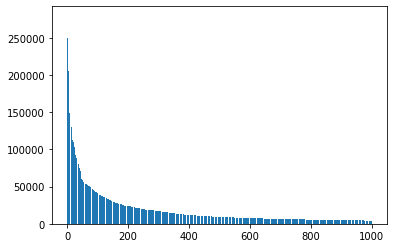

In [8]:
def prune_vocabulary(func_names, tokenized_func_names, func_types, max_ct=279e3, min_ct=12, min_len=2, max_len=20):
    word2count = collections.Counter(itertools.chain(*tokenized_func_names))
    word2count = {k: v for k, v in sorted(word2count.items(), key=lambda item: item[1], reverse=True)
                  if min_ct <= v <= max_ct and min_len <= len(k) <= max_len}
    vocab_low_to_high = {k: v for k, v in sorted(word2count.items(), key=lambda item: item[1], reverse=False)}
    print(f"dict size: {len(word2count)}\n\ndict:")
    print(*((k, v) for _, (k, v) in zip(range(10), word2count.items())), "\nreversed dict:", sep='\n')
    print(*((k, v) for _, (k, v) in zip(range(10), vocab_low_to_high.items())), sep='\n')

    word2ind = {w: i for w, i in zip(word2count.keys(), itertools.count())}
    ind2count = {word2ind[w]: freq for (w, freq), _ in zip(word2count.items(), range(1000))}
    plt.bar(ind2count.keys(), ind2count.values())
    plt.show()

    tokenized_func_names_ = []
    func_types_ = []
    func_names_ = []
    for i, (name, tokenized_name, types) in enumerate(zip(func_names, tokenized_func_names, func_types)):
        processed_tokens = [token for token in tokenized_name if token in word2count]
        if processed_tokens:
            tokenized_func_names_.append(processed_tokens)
            func_types_.append(types)
            func_names_.append(name)

    return func_names_, tokenized_func_names_, func_types_

func_names, tokenized_func_names, func_types = prune_vocabulary(func_names, tokenized_func_names, func_types)

Process types

In [9]:
def tokenize_types(func_types):
    type_set = {
        "int", "unsigned int", "char", "unsigned char", "enum", "struct", "void", "long", "unsigned long",
        "float", "double", "short", "unsigned short", "bool", "union", "long long", "unsigned long long"}
    type_dict = {re.compile(t): t for t in type_set}
    re_drop = re.compile(r"\*|restrict|const")
    struct_type = re.compile("struct")
    tokenized_types = [[0 for _ in range(len(f_types))] for f_types in func_types]
    for i, f_types in enumerate(func_types):
        for j, type in enumerate(f_types):
            cleaned_type = re_drop.sub("", type)
            for re_t, t in type_dict.items():
                if re.search(re_t, cleaned_type):
                    tokenized_types[i][j] = t
                    break
            else:
                tokenized_types[i][j] = type_dict[struct_type]
    return tokenized_types

print(*(func_types[i] for i in range(10)), sep='\n')
tokenized_func_types = tokenize_types(func_types)
print("\n", *(tokenized_func_types[i] for i in range(10)), sep='\n')

['int', 'int', 'int', 'int']
['int', 'long', 'int (*[])()']
['const int *', 'int', 'int']
['int', 'const struct Assoc *', 'int']
['int', 'int *', 'const char *', 'int *']
['int', 'int', 'char **', 'char **']
['void', 'char *', 'char *']
['int', 'const char *', 'void *', 'char *']
['struct sym_quehead *', 'struct sym_quehead *']
['void', 'struct (anonymous at repositories/gimp/image-scale-dialog.c:48:9) *', 'int', 'int']


['int', 'int', 'int', 'int']
['int', 'long', 'int']
['int', 'int', 'int']
['int', 'struct', 'int']
['int', 'int', 'char', 'int']
['int', 'int', 'char', 'char']
['void', 'char', 'char']
['int', 'char', 'void', 'char']
['struct', 'struct']
['void', 'struct', 'int', 'int']


Construct feature matrix

In [10]:
max_samples = int(1e7)
num_samples = min(max_samples, len(func_names))
func_names, tokenized_func_names, func_types, tokenized_func_types = zip(*(random.sample(
    list(zip(func_names, tokenized_func_names, func_types, tokenized_func_types)), k=num_samples)))
tokenized_features = [tok_name + tok_types for tok_name, tok_types in zip(tokenized_func_names, tokenized_func_types)]
tfidf_matrix = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, sublinear_tf=True)
tfidf_matrix = tfidf_matrix.fit_transform(tokenized_func_names)
print(tfidf_matrix.shape)

(2756458, 42451)


Clustering

In [11]:
n_clusters = 500
n_init = 5
model = KMeans(n_clusters=n_clusters, n_init=n_init)
predictions = model.fit_predict(tfidf_matrix)
# isomap = Isomap(n_components=2)
# transformed = isomap.fit_transform(tfidf_matrix)
# x_axis = transformed[:, 0]
# y_axis = transformed[:, 1]
# plt.scatter(x_axis, y_axis, c=predictions)
# plt.show()
# del transformed, x_axis, y_axis

In [12]:
centers = np.array(model.cluster_centers_)
closest_ct = 10
for i in range(n_clusters):
    center = centers[i].reshape(1, -1)
    cluster_indexes = [j for j, cl in enumerate(predictions) if cl == i]
    cluster_funcs = [func_names[j] for j in cluster_indexes]
    cluster_feats = tfidf_matrix[cluster_indexes, :]
    cluster_dists = euclidean_distances(cluster_feats, center)
    cluster_closest_indexes = np.argpartition(cluster_dists.reshape(-1), closest_ct)
    print(f"cluster{i + 1}")
    for j in range(closest_ct):
        print(cluster_funcs[cluster_closest_indexes[j]])
    print("")

cluster1
sha512
sha1
sha1
sha1_resultHmac
Sha384
sha1_addUncounted
sha1
sha256
sha1
Sha1_GetBlockDigest

cluster2
texticlike_support
is_eotf_supported
is_supported
gleswIsSupported
textregexeq_support
isSupportedMRLE
support
texticregexeq_support
eotf_supported
dawr_supported

cluster3
BOOLEAN
boolean_t
boolean
boolean_b_i
Boolean
boolean_b_b
boolean
Boolean
BOOLEAN
IsBoolean

cluster4
rpsxAND_const
rpsxSLT_consts
rpsxDIVU_consts
rpsxNOR_constt
ins_const
rpsxSLT_constt
p1_const
rpsxSLTIU_const
isConst
is_const

cluster5
test_vand_u32
test_vand_s32
test_vand_s8
test_vand_s64
test_vand_u16
test_vand_u8
test_vand_u64
test_vand_s16
test_vshrd_n_u64_2
test_vshrd_n_u64

cluster6
dump_ioptable
dump_seama
dump
dump_TLBFuncDesc
dump
_WifiSysInfoBssInfoDump
__dump
TVPTJS2StartDump
dump_rs
pdump

cluster7
list_new
CacheList_New
vpool_new_size
filter_new
new_size
filter_in_list_new
Filter_New
RPEvaluator_NewFilter
block_list_new
packet_list_new

cluster8
emitSuspendExpression
emit_fmt
emitWRPKRU
E